In [1]:
from lightroot.tracking import tpctree
from lightroot import plots
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
%matplotlib inline
result = tpctree.process_file("./cached_datax/data.csv",start=0,end=400,
                              options={"transforms":True, 
                                       "epsilon":17, 
                                       "use_tr_concensus": True,
                                       "debug": False,
                                       "lags" : [1,2,3]
                                      })
# result.data.to_csv("./cached_datax/data.csv.temp")
# result.stats.to_csv("./cached_datax/data.csv.stats")

100%|████████████████████████████████████████████████████████████████████████████████| 369/369 [03:09<00:00,  1.95it/s]


# Why that transform?

In [ ]:
#does the proposed marry more objects that the identity and is this the same as a score question
#double check the general affine sort
t = 14#50
#these are avail if we set debug=True on the tree
result._test_scores[t-1].head()

In [ ]:
#t= 50
fig, AX = plt.subplots(1, 3, figsize=(20, 6), tight_layout=True)
transform_seed = np.array([[3],[3]])
transform_seed = np.array([[1],[0]])
#transform_seed = np.array([[4],[0]])
transform_seed = None
result.plot_transition(t=t,use_keys=False, transform_seed=transform_seed,splot_tuple=(fig,AX), epsilon=17)

In [ ]:
#check the scores - as many matches as non eps+1 values

In [ ]:
t1 = result[t].reset_index()
t2 = result[t+1].reset_index()
tr = tpctree.find_transform_from_dataframe_rows(t1,t2,transform_seed)
res, score,TR = tpctree.__apply__(tr, t1,t2,17)
print(score)
eps = 17


# Lags
requires having run the tree with lags enabled beyond 1 - see first cell where we create the tracker- lags should be [1,2,3]

how many are outside of ellipse?

In [2]:
lm = tpctree.make_life_matrix(result.data,restricted=False).astype(int)
ageMat = lm.cumsum(axis=1) * lm
#ageMat

In [3]:
#result.data.iloc[487]

In [4]:
def doit(data):
    lm = tpctree.make_life_matrix(data,restricted=False).astype(int)
    ageMat = lm.cumsum(axis=1) * lm
    def age_at(t,i):return ageMat[t][i]
    def age_at_px(row): return age_at(row["t"],row["key"])
    def max_age_at(i):return ageMat.iloc[i].max()
    def max_age_at_px(row): 
        i = int(row["key"])
        try:
            return ageMat.iloc[i].max()#row["key"] 
        except:
            print(i)
             
    data["age"]=data.reset_index().apply(age_at_px, axis=1)
    data["max_age"]=data.reset_index().apply(max_age_at_px, axis=1)
    return data

    
#doit(result.data)

In [5]:
D = doit(result.data)[["key", "key2", "key3", "t", "age", 
                   "epsilon1","epsilon2", "epsilon3"]].dropna()

487
487
487
487
487
487
487
487
488
487
489
488
487
490
488
487
488
488
491
488
491
488
491
488
491
488
491
488
491
488
491
488
491
488
491
488
491


In [6]:
lm = tpctree.make_life_matrix(result.data,restricted=False).astype(int)
ageMat = lm.cumsum(axis=1) * lm

age_spine = ageMat.max(axis=1).reset_index().drop("index",1)
age_spine.columns = ["max_age"]

#D.set_index("key").join(age_spine[["max_age"]]) 

#D.set_index("key").join(D.groupby("key").max()[["age"]], rsuffix="_max")

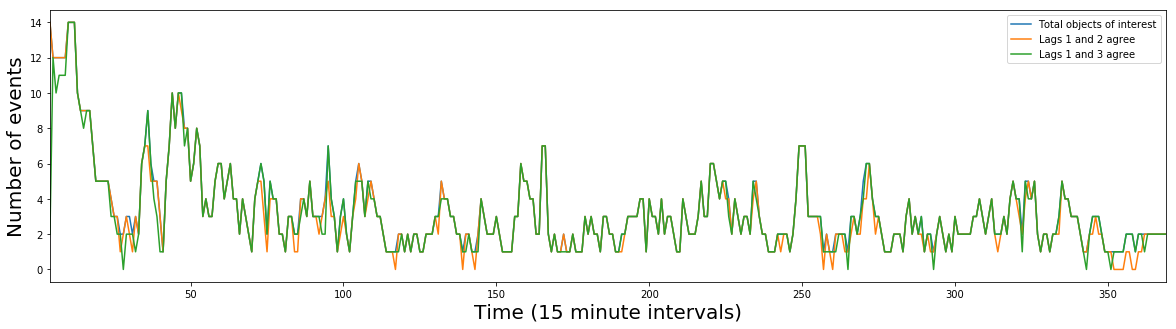

In [9]:
def add_conditional_lag_key_agreement(d):
    d["lag1_2"] = 1
    d["lag1_3"] = 1
    #do ont agree on 1
    d.loc[(d["key"] != d.key2) & (d.age > 2), "lag1_2"] = 0
    #aggree on 2 but not on 3
    d.loc[(d["key"] != d.key3) & (d["key"] == d.key2)  & (d.age > 3), "lag1_3"] = 0
    return d


def doit(data):
    lm = tpctree.make_life_matrix(data,restricted=False).astype(int)
    ageMat = lm.cumsum(axis=1) * lm
    
    age_spine = ageMat.max().reset_index().drop("index",1)
    age_spine.columns = ["max_age"]

    def age_at(t,i):return ageMat[t][i]
    def age_at_px(row): return age_at(row["t"],row["key"])
    def max_age_at(t,i):return ageMat.iloc[i].max()
    def max_age_at_px(row): return max_age_at(row["t"],row["key"]) 
    data["age"]=data.reset_index().apply(age_at_px, axis=1)
    data= data.set_index("key").join(data.groupby("key").max()[["age"]], rsuffix="_max")
    return data.reset_index()

    
_d = doit(result.data)[["key", "key2", "key3", "t", "age", "age_max", "epsilon1","epsilon2", "epsilon3"]].dropna()
for k in ["key", "key2", "key3"]:  _d[k] = _d[k].astype(int)
    
#excluding single frame detections
_d = _d[_d.age_max>1]
counts = _d.groupby("t").count()[["key"]]
counts.columns = ["total"]
_d = add_conditional_lag_key_agreement(_d)

#now create "d" aggregates
d = _d.groupby("t").sum().join(counts)
d["2missing"] = (d["total"]-d["lag1_2"])
d["3missing"] = (d["total"]-d["lag1_3"])
d["l12norm"] = d["2missing"]/d["total"]
d["l13norm"] = d["3missing"]/d["total"]
d["cummulative2"] = d["2missing"].cumsum()
d["cummulative3"] = d["3missing"].cumsum()
d["cummulativeTot"] = d["total"].cumsum()
#ax=d[["cummulative2", "cummulative3", "cummulativeTot"]].plot(figsize=(20,5),logy=True)
ax.set_ylabel("Cummulative",fontsize=14)
ax.xaxis.set_visible(False)
ax=d[["total", "lag1_2", "lag1_3"]].rename(columns={"total":"Total objects of interest", 
                                                    "lag1_2" : "Lags 1 and 2 agree",
                                                    "lag1_3" : "Lags 1 and 3 agree"}).plot(figsize=(20,5))#kind='area',alpha=0.2,stacked=False,
ax.set_xlabel("Time (15 minute intervals)",fontsize=20)
ax.set_ylabel("Number of events",fontsize=20)
ax.figure.savefig("./samples/Fig12.pdf",bbox_inches='tight')


# Why lag discrepancy?
the case of 9

In [ ]:
#when stuff fails why does it fail: fluctuations, angles, ellipse....
# worst = result.data.groupby("key")[["epsilon1"]].max()
# worst = result.data.groupby("key")[["epsilon1"]].mean()
# worst = result.data.groupby("key")[["epsilon1"]].sum()
# worst.columns = ["error"]
# worst.sort_values("error",ascending=False)

In [ ]:
# result = tpctree.process_file("./cached_datax/data.csv",start=0,end=50,options={"transforms":False, "epsilon":18, "use_tr_concensus": True})
# withconc = pd.DataFrame([result.stats[k] for k in result.stats.keys()])
# #withconc["best_tr"].plot()
# result = tpctree.process_file("./cached_datax/data.csv",start=0,end=50,options={"transforms":False, "epsilon":18, "use_tr_concensus": False})
# without = pd.DataFrame([result.stats[k] for k in result.stats.keys()])
# joined = without.join(withconc,rsuffix="with")[["best_tr", "best_trwith"]]#[0:10].plot()
# joined["diff"] = joined["best_tr"]- joined["best_trwith"]
# joined["diff"].plot()

def plot_scores_and_ref_tr(scores,crowd_tr, ax=None):
    if ax == None:fig, (ax) = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
    zoom = 50
    colour = "Blues"
    
    #checks
    scores = scores.dropna()
    scores["x"] = scores["x"].astype(float)
    scores["y"] = scores["y"].astype(float)

    s = ax.scatter(scores["x"], scores["y"], s = 30, c = scores["score"],  marker = "x", cmap=colour, label="Arbitrary transformations")
    scores[scores["type"]=="handpicked"].plot(kind='scatter', x="x", y="y", s = 100, c = "score", facecolors='none', edgecolors='b',  
                                              cmap=colour,ax=ax,colorbar=False, label="Handpicked inlier transformations")
    ax.scatter(x=[crowd_tr.ref_vector[0]], y=[crowd_tr.ref_vector[1]], s=150, facecolors='red', edgecolors='w', marker='o',cmap=colour, label="Concensus transformation")
    ax.axvline(x=0, ymin=0.25, ymax=0.75)
    ax.axhline(y=0, xmin=0.25, xmax=0.75)
    ax.set_ylim(-zoom,zoom)
    ax.set_xlim(-zoom,zoom)

    cb = plt.colorbar(s,make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
    cb.ax.tick_params(labelsize=12)
    ax.legend()


# Displacements

In [ ]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update({'font.size': 14})

titles = [
    "(a) Transformation e.g. taking (blue) 10 to (green) 9",
    "(b) Consensus: displacement mean",
    "(c) More accurate consensus transformation"
]

fig, (ax1,ax5,ax4) = plt.subplots(1, 3, figsize=(20, 6), tight_layout=True)
t=1
eps = 18
#get the concensus from some of these
marriages = np.array([[10,9], [11,10], [0,0],[1,1], [12,11], [9,8], [7,7],[5,4],[4,5],[3,3],[6,6],[2,2]])
scores = tpctree.translations_from_marriages(result[t],result[t+1],mar=marriages,name="handpicked").dropna()
#temporary
scores["type"] = "handpicked" # i think i chagned the internal code for how it names things. todo
crowd_tr, score, _ = tpctree.concensus_best_from_scores(result[t],result[t+1], scores, eps=eps)
rand_scores = tpctree.translations_from_marriages(result[t],result[t+1],name="random")
scores = pd.concat([scores,rand_scores]).dropna()
#plot the sample seed one
transform_seed=np.array([[10],[9]])
result.plot_transition(t=t,use_keys=False, transform_seed=transform_seed, splot_tuple=(fig,(None,None,ax1 )))
#plot the concensus one
plots.plot_proposal(result[t],result[t+1],crowd_tr,ax=ax4,use_keys=False)
#plot scores
plot_scores_and_ref_tr(scores,crowd_tr,ax=ax5)    

for i, ax in enumerate([ax1,ax5,ax4]):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.yaxis.label.set_visible(False)
    #ax.xaxis.label.set_visible(False)
    ax.set_xlabel(titles[i],fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("./samples/Fig03.pdf",bbox_inches='tight')

In [ ]:
tpctree.translations_from_marriages(result[t],result[t+1],mar=marriages,name="handpicked").dropna()

# Angles

In [ ]:
matplotlib.rcParams.update({'font.size': 20})
t= 35
fig, (a3,a4 )= plt.subplots(1,2, figsize=(17, 8),subplot_kw={'aspect': 1})
result.plot_transition(t=t,transform_seed=np.array([[1],[1]]),use_keys=True,epsilon=100, splot_tuple=(fig,(None,None,a3)))
#aim.imshow(fr.sum(0), "Blues")
#result.plot_transition(t=t,transform_seed=np.array([[1],[1]]),use_keys=True,epsilon=200, splot_tuple=(fig,(None,None,aim)))
entry = result.stats.iloc[t]
angles = pd.DataFrame(entry["marriage_angles"]).set_index("key").dropna()#[0:5]
plots.plot_disp_angles(entry["best_tr_angle"], angles.values, angles.index,ax=a4)

for i, ax in enumerate([aim,a3,a4]):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.set_xlabel(titles[i],fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False) 
#a3.set_ylim(a3.get_xlim()[::-1])
#aim.set_ylim(a3.get_ylim())
#aim.set_xlim(a3.get_xlim())
plt.subplots_adjust(wspace=0.02, hspace=0)
fig.savefig("./samples/angle_check.pdf",bbox_inches='tight')

# angles movie

In [ ]:
#show the changing angles
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML
fig,ax = plt.subplots(1,1,figsize=(10,10))
def update(t):
    entry = result.stats.iloc[t]
    angles = pd.DataFrame(entry["marriage_angles"]).set_index("key").dropna()#[0:5]
    ax.clear()
    plot_disp_angles(entry["best_tr_angle"], angles.values, angles.index,ax=ax)
    ax.set_title("Frame"+str(t)) 
ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(result.stats))
ok = HTML(ani.to_html5_video())
#ani.save('./samples/angles.mp4', fps=1)